In [1]:
import pandas as pd
import numpy as np
import re

import time
import warnings
warnings.filterwarnings("ignore")

In [124]:
df = pd.read_csv("raw data/podcasts.csv")
podcasts = pd.read_csv("raw data/episodes.csv")

# making genre dummy columns
genres = list(set([g for g in df["categories"] if not " | " in g]))
for g in genres:
    df[f"{g}_genre"] = [1 if g in cell else 0 for cell in df["categories"]]
genre_cols = [f"{g}_genre" for g in genres]

episodes = podcasts[["title","podcast_uuid","audio", "description", "audio_length"]]
merging = df[["uuid", "language", "title", ]+genre_cols]

combined = episodes.merge(merging, left_on="podcast_uuid", right_on="uuid" )
english_pods = combined[combined["language"] == "English"]
final_pods = english_pods[["title_x", "audio", "description", "audio_length", "title_y",]+genre_cols]

In [3]:
final_pods["text"] = final_pods["title_x"] + " " + final_pods["description"]
final_pods["text"] = final_pods["text"].str.lower()
final_pods.drop_duplicates(subset="text", inplace=True)
final_pods.dropna(inplace=True)
final_pods.reset_index(drop=True, inplace=True)

final_pods.to_csv("raw data/genre_training.csv", index=False)

In [4]:
final_pods = pd.read_csv("raw data/genre_training.csv")

genre_training = final_pods[["text"]+ genre_cols]
genre_training.dropna(inplace=True)
genre_training.reset_index(drop=True, inplace=True)

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


In [58]:
for col in genre_cols:
    print(f"{col} composition: {np.round(genre_training[col].mean() * 100, 2)}")

NameError: name 'genre_cols' is not defined

In [75]:
def multiple_2s(n):
    multiple = 2
    multiples = []
    while multiple in range(n+1):
        multiples.append(multiple)
        multiple *= 2
    return multiples[-1]

In [76]:
multiple_2s(100)

64

In [11]:
g = "Kids & Family_genre"
def genre_df(df, col):
#   
    np.random.seed(42)
    genre = df[df[col] == 1]   
    other = df[df[col] == 0]
    rand_balance = np.random.choice(other.index, genre.shape[0]*3)
    balance = df.iloc[list(rand_balance),:]

#     return dataframe and my X & y variable
    return pd.concat([genre, balance])

In [9]:
data = genre_training

In [11]:
for i, text in zip(data.index, data.text):
    data["text"][i] = re.sub("<[^>]*>", "", text)

In [8]:
data.to_csv("Cleaned data/html_free_podcasts.csv", index=False)

In [9]:
data = pd.read_csv("Cleaned data/html_free_podcasts.csv")

In [13]:
df = genre_df(data, g)

In [34]:
X = df["text"]
y = df["Kids & Family_genre"]
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

features = 4000

tvec = TfidfVectorizer(stop_words="english",
                       ngram_range = (1,2),
                       max_features = features)
X_train_vec = tvec.fit_transform(X_train)
X_test_vec = tvec.transform(X_test)

In [14]:
(X_train_vec.todense()).shape

(360208, 2000)

In [35]:
nodes_1 = multiple_2s(features)
nodes_2 = multiple_2s(features)

In [36]:
model = Sequential()

model.add(Dense(nodes_1, 
                activation="relu", 
                input_shape=(features,),
               ))
model.add(Dropout(.2))
model.add(Dense(nodes_2, 
                activation="relu",
               ))
model.add(Dropout(.2))
model.add(Dense(1, 
                activation = "sigmoid",
               ))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics = ["acc"]
)

mod_hist= model.fit(X_train_vec.todense(), y_train,
          batch_size=(multiple_2s(features)),
          validation_data = (X_test_vec.todense(), y_test),
          epochs = 6
         )

Train on 28461 samples, validate on 9487 samples
Epoch 1/6
28461/28461 [==============================] - 13s 460us/sample - loss: 0.5190 - acc: 0.7367 - val_loss: 0.4444 - val_acc: 0.7500
Epoch 2/6
28461/28461 [==============================] - 13s 450us/sample - loss: 0.3899 - acc: 0.7689 - val_loss: 0.4007 - val_acc: 0.8096
Epoch 3/6
28461/28461 [==============================] - 13s 451us/sample - loss: 0.3226 - acc: 0.8521 - val_loss: 0.3939 - val_acc: 0.8472
Epoch 4/6
28461/28461 [==============================] - 13s 458us/sample - loss: 0.2626 - acc: 0.9064 - val_loss: 0.4012 - val_acc: 0.8566
Epoch 5/6
28461/28461 [==============================] - 13s 457us/sample - loss: 0.1874 - acc: 0.9551 - val_loss: 0.4273 - val_acc: 0.8594
Epoch 6/6
28461/28461 [==============================] - 13s 450us/sample - loss: 0.0972 - acc: 0.9748 - val_loss: 0.4890 - val_acc: 0.8566


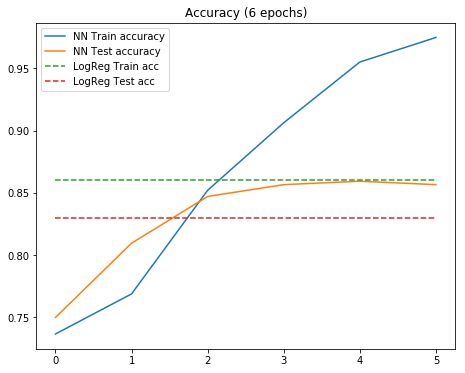

In [78]:
plt.figure(figsize=(7.5,6))
plt.plot(mod_hist.history['acc'], label='NN Train accuracy')
plt.plot(mod_hist.history['val_acc'], label='NN Test accuracy')
plt.plot([0.86]*6,"--", label="LogReg Train acc")
plt.plot([0.83]*6,"--", label="LogReg Test acc")
plt.legend();
plt.title("Accuracy (6 epochs)")
plt.show()

In [ ]:
mod_hist.history['val_acc']

In [20]:
1- y.mean()

0.75

In [53]:
from sklearn.linear_model import LogisticRegression
import pickle

In [38]:
logr = LogisticRegression()

logr.fit(X_train_vec.todense(), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
logr.score(X_train_vec.todense(), y_train)

0.8651488001124346

### Producing & Saving all the models needed
_______________________________________

In [64]:
genre_cols = list(data.columns[data.columns.str.contains("_genre")])

In [80]:
# Produce a df that is able to 
for g in genre_cols:
    df = genre_df(data, g)


    X = df["text"]
    y = df[g]
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

    features = 4000

    tvec = TfidfVectorizer(stop_words="english",
                           ngram_range = (1,2),
                           max_features = features)
    X_train_vec = tvec.fit_transform(X_train)
    X_test_vec = tvec.transform(X_test)

    logr = LogisticRegression()

    logr.fit(X_train_vec.todense(), y_train)

    train_score = logr.score(X_train_vec.todense(), y_train)
    test_score = logr.score(X_test_vec.todense(), y_test)

    print(f"Finished {g.replace('_genre', '')} genre \n", 
          f"training score: {train_score} \n",
          f"testing score: {test_score} \n \n")

    pickle.dump(logr, open(f"Genre models/{g}.sav", "wb"))

Finished Arts genre 
 training score: 0.8282569825513287 
 testing score: 0.8114865281460016 
 

Finished Science & Medicine genre 
 training score: 0.8785614551492509 
 testing score: 0.8509000339635457 
 

Finished Sports & Recreation genre 
 training score: 0.9262771824663684 
 testing score: 0.9240327900261389 
 

Finished News & Politics genre 
 training score: 0.8734077271291715 
 testing score: 0.8690125276344879 
 

Finished Comedy genre 
 training score: 0.8350004763265695 
 testing score: 0.8252028051970893 
 

Finished Music genre 
 training score: 0.8908470437532525 
 testing score: 0.8843220847844362 
 

Finished Government & Organizations genre 
 training score: 0.869261656478485 
 testing score: 0.850683207479324 
 

Finished Society & Culture genre 
 training score: 0.7877856508397932 
 testing score: 0.7786912548449613 
 

Finished Kids & Family genre 
 training score: 0.8652893433119005 
 testing score: 0.8409402340044271 
 

Finished Business genre 
 training score: 

### making predictions on the transcripts available
______________________

In [97]:
tal = pd.read_csv("Cleaned data/TAL_clean.csv")

In [98]:
for g in genres:

    model = pickle.load(open(f"Genre models/{g}.sav","rb"))

    df = genre_df(data, f"{g}")

    X = df["text"]
    y = df[f"{g}"]
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

    features = 4000

    tvec = TfidfVectorizer(stop_words="english",
                           ngram_range = (1,2),
                           max_features = features)
    X_train_vec = tvec.fit_transform(X_train)
    tal_X = tvec.transform(tal["text"])

    yhat = model.predict(tal_X.todense())

    tal = tal.join(pd.DataFrame(yhat, columns=[f"{g}"]))

In [99]:
tal.head()

,title,text,Arts_genre,Science & Medicine_genre,Sports & Recreation_genre,News & Politics_genre,Comedy_genre,Music_genre,Government & Organizations_genre,Society & Culture_genre,Kids & Family_genre,Business_genre,Health_genre,Games & Hobbies_genre,Education_genre,Religion & Spirituality_genre,Technology_genre,TV & Film_genre
0,New Beginnings,joe franklin i am ready it is ira glass here...,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,Small Scale Sin,ok three boys aged 13 15 and 16 all three cho...,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
2,Poultry Slam 1995,in danielle s house ever since she was a girl...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Vacations,the thing about hawaii is that before you go ...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Anger and Forgiveness,hi it is ira glass recording this in 2006 and...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [141]:
col_sum = {}

for g in genre_cols:
    col_sum.update({g: sum(tal[g])})

In [101]:
col_sum

{'Arts_genre': 263,
 'Science & Medicine_genre': 224,
 'Sports & Recreation_genre': 12,
 'News & Politics_genre': 4,
 'Comedy_genre': 4,
 'Music_genre': 1,
 'Government & Organizations_genre': 132,
 'Society & Culture_genre': 23,
 'Kids & Family_genre': 81,
 'Business_genre': 201,
 'Health_genre': 324,
 'Games & Hobbies_genre': 65,
 'Education_genre': 81,
 'Religion & Spirituality_genre': 0,
 'Technology_genre': 136,
 'TV & Film_genre': 48}

In [102]:
tal[tal["comedy_genre"] ==1]

,title,text,Arts_genre,Science & Medicine_genre,Sports & Recreation_genre,News & Politics_genre,Comedy_genre,Music_genre,Government & Organizations_genre,Society & Culture_genre,Kids & Family_genre,Business_genre,Health_genre,Games & Hobbies_genre,Education_genre,Religion & Spirituality_genre,Technology_genre,TV & Film_genre
103,Music Lessons,here s my seventh grade teacher s sad fate h...,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1


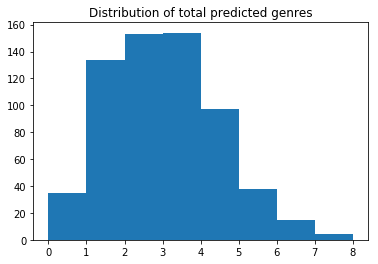

In [140]:
tal["total_genres"] = 0
for g in genre_cols:
    tal["total_genres"] += tal[g]
    
    
plt.title("Distribution of total predicted genres")
plt.hist(tal["total_genres"], bins = 8)
plt.show();
tal.drop(columns="total_genres", inplace=True)

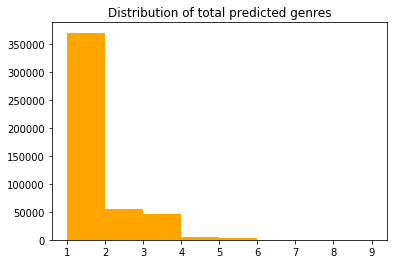

In [111]:
data["total_genres"] = 0
for g in genres:
    data["total_genres"] += data[g]
    
    
plt.title("Distribution of total actual genres")
plt.hist(data["total_genres"], bins = 8, color ="orange")
plt.show();

In [127]:
final_pods.rename(columns ={"title_x": "title", "description":"text"}, inplace=True)

In [131]:
final_pods.rename(columns={"episode_title":"title"}, inplace = True)

In [135]:
final_pods = final_pods[["title", "text",]+genre_cols]

In [ ]:
final_pods.dropna(inplace=True)

In [153]:
corpus = pd.concat([tal, final_pods])

In [156]:
corpus.to_csv("Recommender files/corpus.csv", index=False)

In [ ]:
# models = {}
# for g in genre_cols:
#     print(f"fitting best model for {g}")
#     time_0 = time.time()
    
# #     creating a balanced class
#     genre = genre_training[genre_training[g] == 1]   
#     other = genre_training[genre_training[g] == 0]
#     rand_balance = np.random.choice(other.index, genre.shape[0]*2)
#     balance = genre_training.iloc[list(rand_balance),:]

# #     creating dataframe and my X & y variable
#     df = pd.concat([genre, balance])
#     X = df["text"]
#     y = df[g]

#     pipe = Pipeline([
#         ("tvec", TfidfVectorizer()),
#         ("rfclass", RandomForestClassifier()),
#     ])
#     pipe_params = {
#         "tvec__stop_words": ["english"],
#         "tvec__ngram_range": [(1,1)],
#         "tvec__max_features": list(range(500, 700, 50)),
#         "rfclass__n_estimators": list(range(10,50,10)),
#         "rfclass__min_samples_split": list(range(2,10,2)),
#     }
    
#     grid = GridSearchCV(pipe,
#                         pipe_params,
#                         cv=3,
#                         verbose=1,
#                         n_jobs = -1)
#     grid.fit(X,y)
    
#     print(f"Done modeling {g}")
    
#     null = np.round(1- genre_training[g].mean(), 5)
#     best_model = grid.best_estimator_
#     score = np.round(grid.best_score_)
#     models.update({g:{
#         "best_model": best_model,
#         "score": score,
#         "grid": grid
#     }})
#     print(f"accuracy score: {score}")    
#     if score <= null:
#         print(f"the null model ({null}) for {g} ({(score)}) performs better by {np.round(null-score, 3)} points \n \n")